In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras import regularizers
import os
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras as ks
from sklearn.preprocessing import MinMaxScaler


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/merged_data.csv', index_col='ts', parse_dates=True)

In [ ]:
dataset

In [ ]:
cols = ['event_lte_freq', 'event_band']

dataset2 = dataset.drop(columns=cols, axis=1)

In [ ]:
num_rows = len(dataset)
subset_size = int(num_rows * 0.75)

subset_df = dataset.iloc[:subset_size]

In [ ]:
# Class weights calculation
neg, pos = np.bincount(dataset['anomaly_label'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
adjusted_weight_for_0 = weight_for_0 * 1.0  # Example: decrease if too many false positives
adjusted_weight_for_1 = weight_for_1 * 1.0  # Example: increase if too many false negatives

class_weight = {0: adjusted_weight_for_0, 1: adjusted_weight_for_1}
time_steps = 30  # Adjust based on your sequence length
batch_size = 128 # Adjust based on your batch size preference
output_size = 1

In [ ]:
neg

476474

In [ ]:
def create_sequences(values, time_steps=10):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
# Split data function
def split_data_chronologically(data, test_ratio=0.2, val_ratio=0.2, target_column='anomaly_label'):
    total_samples = len(data)
    test_split_idx = int(total_samples * (1 - test_ratio))
    val_split_idx = int(test_split_idx * (1 - val_ratio / (1 - test_ratio)))

    train_data = data.iloc[:test_split_idx]
    test_data = data.iloc[test_split_idx:]

    train_labels = train_data[target_column].values
    test_labels = test_data[target_column].values


    return train_data, test_data, train_labels, test_labels

# Scale data function
def scale_data(train_data,test_data, target_column='anomaly_label'):

    scaler = StandardScaler()

    # Fit on training data
    train_features = train_data.drop(columns=[target_column])
    scaler.fit(train_features)

    train_anomalies = train_data[train_data[target_column] == 1]  # Assuming 'anomaly' is the column indicating anomalies
    train_non_anomalies = train_data[train_data[target_column] == 0]
    test_anomalies = test_data[test_data[target_column] == 1]  # Assuming 'anomaly' is the column indicating anomalies
    test_non_anomalies = test_data[test_data[target_column] == 0]

    # Transform features
    train_scaled = scaler.transform(train_features)
    train_a_scaled = scaler.transform(train_anomalies.drop(columns=[target_column]))
    train_na_scaled = scaler.transform(train_non_anomalies.drop(columns=[target_column]))
    test_a_scaled = scaler.transform(test_anomalies.drop(columns=[target_column]))
    test_na_scaled = scaler.transform(test_non_anomalies.drop(columns=[target_column]))
    test_scaled = scaler.transform(test_data.drop(columns=[target_column]))




    return train_scaled, train_a_scaled, train_na_scaled,test_a_scaled, test_na_scaled, test_scaled

# Create TensorFlow dataset function
def create_tf_dataset(features, labels, time_steps=100, batch_size=32, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=features,
        targets=features,
        sequence_length=time_steps,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return dataset


def create_tf_dataset2(features, time_steps=100, batch_size=32, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=features,
        targets=np.roll(features, -time_steps),  # Using features as targets
        sequence_length=time_steps,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return dataset






# Define metrics
METRICS = [
      ks.metrics.MeanSquaredError(name='MSE'),
      ks.metrics.TruePositives(name='tp'),
      ks.metrics.FalsePositives(name='fp'),
      ks.metrics.TrueNegatives(name='tn'),
      ks.metrics.FalseNegatives(name='fn'),
      ks.metrics.BinaryAccuracy(name='accuracy'),
      ks.metrics.Precision(name='precision'),
      ks.metrics.Recall(name='recall'),
      ks.metrics.AUC(name='auc'),
      ks.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
x_normal_train =create_sequences(train_na_scaled, time_steps=32)

In [ ]:
x_anomaly_train =create_sequences(train_a_scaled, time_steps=32)

In [ ]:
x_total_train =create_sequences(train_scaled, time_steps=32)

In [ ]:
train_data, test_data, train_labels, test_labels = split_data_chronologically(dataset)
train_scaled, train_a_scaled, train_na_scaled,test_a_scaled, test_na_scaled, test_scaled = scale_data(train_data, test_data)

    # Dataset Creation
#train_dataset = create_tf_dataset2(train_scaled, time_steps=time_steps, batch_size=batch_size, shuffle=False)
#val_dataset = create_tf_dataset2(val_scaled,time_steps=time_steps, batch_size=batch_size, shuffle=False)
#test_dataset = create_tf_dataset(test_scaled, test_labels, time_steps=time_steps, batch_size=batch_size, shuffle=False)
#num_features = train_scaled.shape[-1]
#input_shape = (time_steps, train_scaled.shape[-1])

In [ ]:
from keras import layers
import keras

from keras import layers, Sequential
model = keras.Sequential(
    [
        layers.Input(shape=(x_normal_train.shape[1], x_normal_train.shape[2])),
        layers.Conv1D(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="tanh",
        ),
        layers.Dropout(rate=0.1),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="tanh",
        ),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="tanh",
        ),
        layers.Dropout(rate=0.1),
        layers.Conv1DTranspose(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="tanh",
        ),
        layers.Conv1DTranspose(filters=9, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 16, 64)            4096      
                                                                 
 dropout_4 (Dropout)         (None, 16, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 32)             14368     
                                                                 
 conv1d_transpose_6 (Conv1D  (None, 16, 32)            7200      
 Transpose)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 16, 32)            0         
                                                                 
 conv1d_transpose_7 (Conv1D  (None, 32, 64)            14400     
 Transpose)                                           

In [ ]:
model2 = Sequential([
    layers.Input(shape=(x_normal_train.shape[1], x_normal_train.shape[2])),

    # Encoder
    layers.GRU(64, activation="relu", return_sequences=True),
    layers.Dropout(rate=0.2),
    layers.GRU(32, activation="relu"),  # Note: return_sequences is False by default
    layers.Dropout(rate=0.2),

    # RepeatVector for reshaping the single vector output from the encoder
    layers.RepeatVector(x_normal_train.shape[1]),  # Repeat the vector to match the sequence length

    # Decoder
    layers.GRU(32, activation="relu", return_sequences=True),
    layers.Dropout(rate=0.2),
    layers.GRU(64, activation="relu", return_sequences=True),
    layers.Dropout(rate=0.2),

    # Output layer
    layers.TimeDistributed(layers.Dense(x_normal_train.shape[2])),
])

model2.compile(optimizer='adam', loss='mae')
model2.summary()

In [ ]:
validation_size = int(len(x_total_train) * 0.7)

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

history1 = model.fit(
    x_normal_train,
    x_normal_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_anomaly_train, x_anomaly_train),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        , lr_callback
    ],
)


Epoch 1/30
31645/31656 [============================>.] - ETA: 0s - loss: 0.0396

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

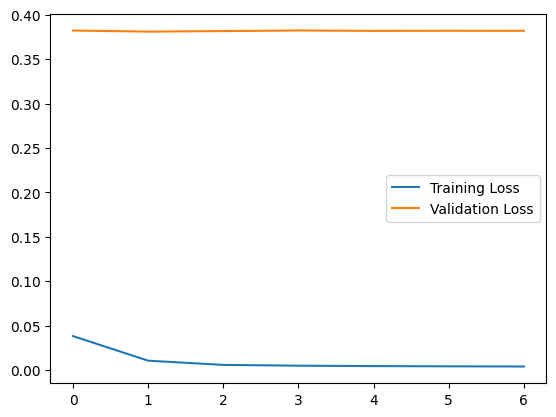

In [ ]:
plt.plot(history1.history["loss"], label="Training Loss")
plt.plot(history1.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/cnn_greatestever.keras")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/cnn_auto.keras")

In [ ]:
# Get train MAE loss.
with tf.device('/CPU:0'):
    x_norm_train_pred = model.predict(x_normal_train)

63311/63311 [==============================] - 167s 3ms/step


In [ ]:
with tf.device('/CPU:0'):
    train_loss = tf.keras.losses.mae(x_normal_train, x_norm_train_pred)

In [ ]:

scaling_factor=3

# Get reconstruction loss threshold.
threshold = np.mean(train_loss) + np.std(train_loss) * scaling_factor
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.2130364216864109


In [ ]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

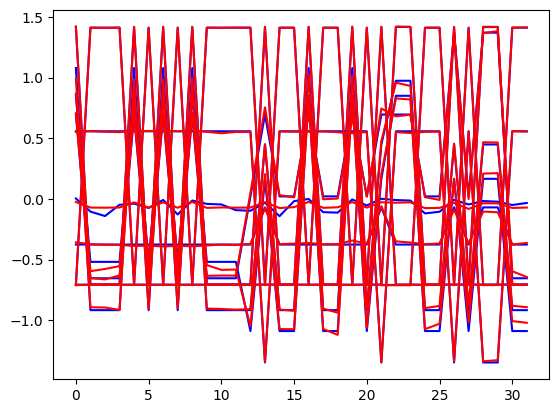

In [ ]:
plt.plot(x_normal_train[0], 'b')
plt.plot(x_norm_train_pred[0], 'r')
plt.show()

In [ ]:
x_anomaly_pred = model.predict(x_anomaly_train)

with tf.device('/CPU:0'):
    test_loss = tf.keras.losses.mae(x_anomaly_pred, x_anomaly_train)

26848/26848 [==============================] - 41s 2ms/step


In [ ]:
scaling_factor=3

# Get reconstruction loss threshold.
threshold_ano = np.mean(test_loss) + np.std(test_loss) * scaling_factor
print("Reconstruction error threshold: ", threshold_ano)

Reconstruction error threshold:  0.825954169031101


In [ ]:
y_true = np.concatenate([np.zeros(len(train_loss)), np.ones(len(test_loss))])

# Concatenating the MSE scores similarly
y_scores = np.concatenate([train_loss, test_loss])

print("y_true length:", len(y_true))
print("y_scores length:", len(y_scores))

y_true length: 2885067
y_scores length: 2885067


In [ ]:
y_scores_aggregated = np.mean(y_scores, axis=1)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores_aggregated)
roc_auc = auc(fpr, tpr)

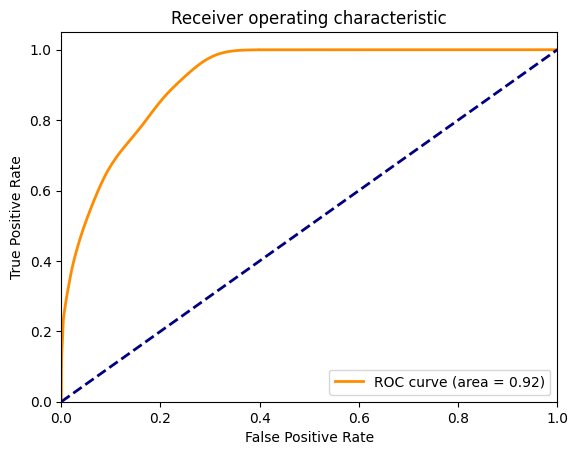

In [ ]:

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]


In [ ]:
optimal_threshold

0.01603269174368835

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores_aggregated)

# Find the threshold that is closest to your target precision
target_precision = 0.70  # Example target
closest_precision_idx = np.argmin(np.abs(precision - target_precision))
closest_precision = precision[closest_precision_idx]
closest_recall = recall[closest_precision_idx]
closest_threshold = thresholds[closest_precision_idx]

print(f'Target Precision: {target_precision}')
print(f'Closest Precision: {closest_precision}')
print(f'Corresponding Recall: {closest_recall}')
print(f'Optimal Threshold: {closest_threshold}')

Target Precision: 0.7
Closest Precision: 0.6999996672578386
Corresponding Recall: 0.7346015916082647
Optimal Threshold: 0.02119267688249238


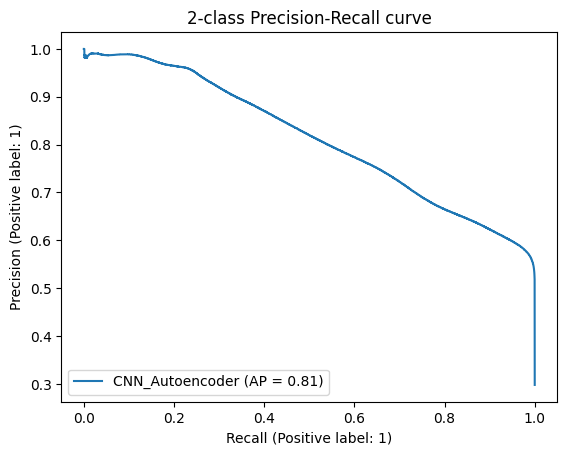

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_true, y_scores_aggregated, name="CNN_Autoencoder")
display.ax_.set_title('2-class Precision-Recall curve')
plt.show()

In [ ]:
def create_sequences_test(values, labels, time_steps=10):
    output_values = []
    output_labels = []
    for i in range(len(values) - time_steps + 1):
        output_values.append(values[i : (i + time_steps)])
        output_labels.append(labels[i + time_steps - 1])  # Assuming labels indicate the anomaly at the last timestep of each sequence
    return np.stack(output_values), np.array(output_labels)

In [ ]:
x_test, test_labels1=create_sequences_test(test_scaled,test_labels,time_steps=32)

In [ ]:
x_test_pred = model.predict(x_test)

with tf.device('/CPU:0'):
    test_final_loss = tf.keras.losses.mae(x_test_pred, x_test)


22540/22540 [==============================] - 36s 2ms/step


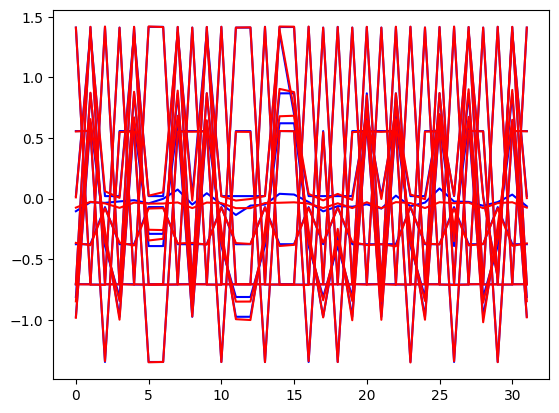

In [ ]:
plt.plot(x_test[0], 'b')
plt.plot(x_test_pred[0], 'r')
plt.show()

In [ ]:
closest_threshold

0.02119267688249238

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_final_loss > closest_threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  6859817
Indices of anomaly samples:  (array([     0,      0,      1, ..., 721251, 721251, 721251]), array([ 7, 14,  6, ..., 27, 28, 30]))


In [ ]:
anomalies

<tf.Tensor: shape=(360611, 32), dtype=bool, numpy=
array([[False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [ True, False,  True, ..., False,  True,  True],
       ...,
       [False,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False,  True],
       [False, False, False, ..., False,  True,  True]])>

In [ ]:
test_labels1.shape

(360611,)

In [ ]:
from sklearn.metrics import roc_curve

flattened_labels = test_labels1.flatten()
flattened_predictions = tf.reshape(test_final_loss, [-1]).numpy()
fpr, tpr, thresholds = roc_curve(flattened_labels, reduced_anomalies_np)

In [ ]:
roc_curve(flattened_labels, reduced_anomalies_np)

(array([0., 1.]), array([0., 1.]), array([2, 1]))

In [ ]:
thresholds

array([2, 1])

In [ ]:
# Reduce the anomalies tensor to a 1D tensor where each entry is True if any of the 32 conditions is True.
reduced_anomalies = tf.reduce_any(anomalies, axis=1)

# Convert the reduced anomalies tensor to a NumPy array for comparison with test_labels.
reduced_anomalies_np = reduced_anomalies.numpy()

# Calculate True Positives (TP) and False Negatives (FN).
TP = np.sum(reduced_anomalies_np & (test_labels1 == 1))
FN = np.sum(~reduced_anomalies_np & (test_labels1 == 1))

FP = np.sum(reduced_anomalies_np & (test_labels1 == 0))
TN = np.sum(~reduced_anomalies_np & (test_labels1 == 0))
# Calculate precision.
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate recall.
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print("Recall: ", recall)
print("Precision: ", precision)




Recall:  0.9835622257988088
Precision:  0.34127687198538387


In [ ]:
FN

4024

In [ ]:
FP

464743

In [ ]:
TP

240778

In [ ]:
TN

11707